In [1]:
%pylab inline
from io import BytesIO
import IPython.display
import hashlib
import struct

from svgpathtools import * 
import cmath

Populating the interactive namespace from numpy and matplotlib


In [2]:
paths, attributes = svg2paths('base.svg')
tops = []
for i in range(1, 4):
    ipaths, iattributes = svg2paths('1t%s.svg' % i)
    tops.append(ipaths)
bottoms = []
for i in range(1, 6):
    ipaths, iattributes = svg2paths('1b%s.svg' % i)
    bottoms.append(ipaths)
    


In [3]:
def nonlinspace(l, u, n, init=b''):
    maxuint = struct.unpack(">I", b"\xff\xff\xff\xff")[0]
    m = hashlib.md5()
    m.update(init)
    res = numpy.zeros(n)
    for i in range(0, n):
        m.update(b'\0')
        res[i] = l + (u-l) * float(struct.unpack(">I", m.digest()[:4])[0]) / maxuint
    return sort(res)

In [4]:
def decorate(pth,
             bottoms,
             tops,
             padding = 5,
             nitems = 40,
             minsize=0.3,
             overlap=0.02,
             flavor = b'firepower2',
             scaling = lambda d: 1-1/(1+e**(-200*abs(d)+3)),
             include_pth=True):

    bases_bottom = [[path.scale(p, 0.5) for p in bottom] for bottom  in bottoms]
    bases_bottom = [[path.translate(p, -bbox[0]-bbox[3]*1j) for p in base]
                    for base, bbox in ((base, paths2svg.big_bounding_box(base)) for base in bases_bottom)]

    bases_top = [[path.scale(p, 0.5) for p in bottom] for bottom  in tops]
    bases_top = [[path.translate(p, -bbox[0]-bbox[2]*1j) for p in base]
                    for base, bbox in ((base, paths2svg.big_bounding_box(base)) for base in bases_top)]

    m = hashlib.md5()

    points = [(T,
               pth[s].point(t),
               cmath.phase(pth[s].unit_tangent(t)) * 360 / (2*pi),
               pth[s].normal(t),
               d
              )
              for T, (s, t), d in ((T, pth.T2t(T), pth.derivative(T, 2)) for T in nonlinspace(0, 1, nitems, flavor))]

    points = [points[i]
              for i in range(len(points))
              if i == 0 or (abs(points[i][0]-points[i-1][0]) * (360-abs(points[i][2]-points[i-1][2]))/360. > overlap)]

    opaths=[base.scaled(scaling(d)).rotated(a if T > .5 else a + 180, 0.0).translated(p).translated(padding*n)
            for idx, (T, p, a, n, d) in enumerate(points)
            for base in (bases_bottom[idx % len(bases_bottom)] if T > .5 else bases_top[idx % len(bases_top)])
            if scaling(d) > minsize]

    if include_pth:
        opaths.append(pth)

    return opaths


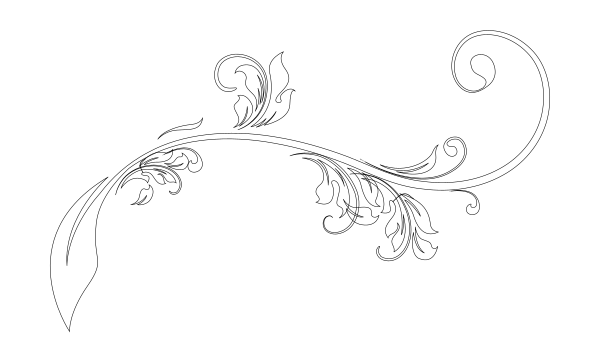

In [5]:
wsvg(decorate(paths[0], bottoms, tops), filename="test.svg")
with open("test.svg", "rb") as f:
    data = f.read()
IPython.display.SVG(data=data)